In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

In [10]:
fc = FileChooser('/sf/alvra/data/p18741/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18741/raw/scan_info', filename='', show_hidden='False')

In [12]:
quantile_band = 0.5
quantile_corr = 0.5
pid_roll = 0

channel_list_pp = [channel_Events, channel_Izero122, 'JF04T01V01']
channel_list_all = channel_list_pp + [channel_energy]

threshold_low = 6.0
threshold_high = 100

threshold_I0_low = 2
threshold_I0_high = 5
####################################################################################################3

json_file = fc.selected
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

XAS_JF_pump = []
XAS_JF_unpump = []
Pump_probe = []

Energy_eV = []

clock = Clock()

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    #print (filename)
    exists = os.path.isfile(filename)
    if exists: # and i !=21:
        clear_output(wait=True)
        print("step", i+1, "of",numFiles, f": Processing {filename}")
        
        filenames = filename.replace('BSREAD', '*')
        resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, filenames)
        
        energy_shot = results[channel_energy]
        
        IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
        IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
        DataJF_pump_shot = resultsPP['JF04T01V01'].pump
        DataJF_unpump_shot = resultsPP['JF04T01V01'].unpump
        
        print ("Loaded {} shots".format(len(IzeroFEL_pump_shot)))
        
        nframes = DataJF_pump_shot.shape[0]
        print (nframes)
        DataJF_pump_shot_thr = np.empty_like(DataJF_pump_shot)
        DataJF_unpump_shot_thr = np.empty_like(DataJF_unpump_shot)
        IzeroFEL_pump_shot_JF = np.empty_like(DataJF_pump_shot)
        IzeroFEL_unpump_shot_JF = np.empty_like(DataJF_unpump_shot)
        
        for j in range(nframes):
            
            image_pump = DataJF_pump_shot[j,:]
            image_unpump = DataJF_unpump_shot[j,:]
    
            image_pump_thr = np.copy(DataJF_pump_shot[j,:])
            image_pump_I0 = np.copy(DataJF_pump_shot[j,:])
            image_unpump_thr = np.copy(DataJF_unpump_shot[j,:])
            image_unpump_I0 = np.copy(DataJF_unpump_shot[j,:])
    
            image_pump_thr[image_pump < threshold_low] = 0
            image_unpump_thr[image_unpump < threshold_low] = 0           
    
            image_pump_thr[image_pump > threshold_high] = 0
            image_unpump_thr[image_unpump > threshold_high] = 0
            
            image_pump_I0[image_pump_I0 < threshold_I0_low] = 0
            image_unpump_I0[image_unpump_I0 < threshold_I0_low] = 0
            
            image_pump_I0[image_pump_I0 > threshold_I0_high] = 0
            image_unpump_I0[image_unpump_I0 > threshold_I0_high] = 0
    
            DataJF_pump_shot_thr[j,:] = np.copy(image_pump_thr)
            DataJF_unpump_shot_thr[j,:] = np.copy(image_unpump_thr)
            
            IzeroFEL_pump_shot_JF [j,:] = np.copy(image_pump_I0)
            IzeroFEL_unpump_shot_JF [j,:] = np.copy(image_unpump_I0)
            
        XASJF_pump_norm = np.roll(DataJF_pump_shot_thr.sum(axis = 1).sum(axis = 1), pid_roll, axis = 0) / IzeroFEL_pump_shot
        XASJF_unpump_norm = np.roll(DataJF_unpump_shot_thr.sum(axis = 1).sum(axis = 1), pid_roll, axis = 0) / IzeroFEL_unpump_shot
        
        #XASJF_pump_norm = np.roll(DataJF_pump_shot_thr.sum(axis = 1).sum(axis = 1), pid_roll, axis = 0) / np.roll(IzeroFEL_pump_shot_JF.sum(axis = 1).sum(axis = 1), pid_roll, axis = 0)
        #XASJF_unpump_norm = np.roll(DataJF_unpump_shot_thr.sum(axis = 1).sum(axis = 1), pid_roll, axis = 0) / np.roll(IzeroFEL_unpump_shot_JF.sum(axis = 1).sum(axis = 1), pid_roll, axis = 0)
        
        Pump_probe_shot = XASJF_pump_norm - XASJF_unpump_norm
    
        df_pump = pd.DataFrame(XASJF_pump_norm)
        df_unpump = pd.DataFrame(XASJF_unpump_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        XAS_JF_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        XAS_JF_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        
        Energy_eV.append(data['scan_readbacks'][i]) ## Delay from the json file
        print ("It took {} s to process {}".format(clock.tick(), filename.split('/')[-1].split('.')[0]))

XAS_JF_pump = np.asarray(XAS_JF_pump)
XAS_JF_unpump = np.asarray(XAS_JF_unpump)
Pump_probe = np.asarray(Pump_probe)

Energy_eV = np.asarray(Energy_eV)

        
print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

step 51 of 51 : Processing /sf/alvra/data/p18741/raw/Co_YIG_monoscan_Co_070/run_005391.BSREAD.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF04T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_001060.JF04T01V01.res.h5
jungfrau file: 12:47 12.12.2020
pedestal file: 11:45 10.12.2020
    mtime difference: 2 days, 1:02:54.611951

--------------------------------------------------------------------------------

JF04T01V01                        2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet           2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2000 / 2000 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 999 pump and 999 unpump shots
L

<IPython.core.display.Javascript object>


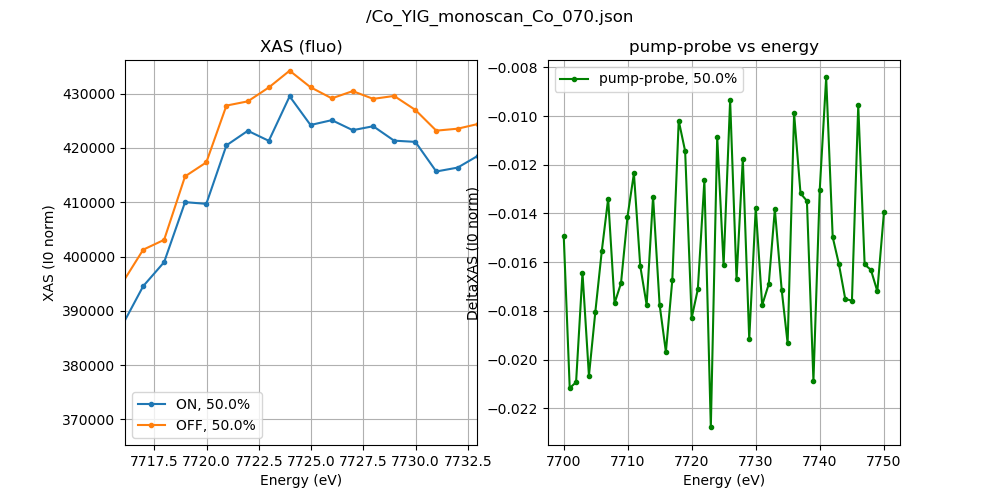

In [13]:
plt.figure(figsize = (10,5))
plt.suptitle(json_file.split('scan_info')[1], fontsize=12)

XAS_pump_probe_relative = (XAS_JF_pump - XAS_JF_unpump) / XAS_JF_unpump
XAS_pump = XAS_JF_pump[:,0]
err_low_pump = XAS_JF_pump[:,1]
err_high_pump = XAS_JF_pump[:,2]
XAS_unpump = XAS_JF_unpump[:,0]
err_low_unpump = XAS_JF_unpump[:,1]
err_high_unpump = XAS_JF_unpump[:,2]
XAS_pump_probe = Pump_probe[:,0]
err_low_pump_probe = Pump_probe[:,1]
err_high_pump_probe = Pump_probe[:,2]

plt.subplot(1,2,1)
plt.plot(Energy_eV, XAS_pump, label='ON, {}%'.format(quantile_band*100),marker='.')
#plt.fill_between(Energy_eV[:,0], err_low_pump, err_high_pump, color='lightblue')

plt.plot(Energy_eV, XAS_unpump, label='OFF, {}%'.format(quantile_band*100),marker='.')
#plt.fill_between(Energy_eV[:,0], err_low_unpump, err_high_unpump, color='navajowhite')

plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Energy_eV, XAS_pump_probe_relative[:,0], label='pump-probe, {}%'.format(quantile_band*100),color='green', marker='.')
#plt.fill_between(Energy_eV,err_low_pump_probe, err_high_pump_probe, color='lightgreen')
plt.xlabel("Energy (eV)")
plt.ylabel ("DeltaXAS (I0 norm)")
plt.gca().set_title('pump-probe vs energy')
plt.legend(loc="best")
plt.grid()

plt.show()



In [22]:
print(err_low_pump)

[3.52923954 3.5782609  3.58393025 3.58729494 3.64142996 3.62663305
 3.64294595 3.55869937 3.61836994 3.57741904 3.62484789 3.64021993
 3.62833536 3.67007172 3.63840866 3.61808062 3.66490638 3.61325598
 3.63732553 3.70884335 3.65948462 3.7526843  3.69963324 3.75864184
 3.71560889 3.76686811 3.80150998 3.71703613 3.77424395 3.69486845
 3.74224234 3.75555259 3.68496048 3.69389111 3.71806091 3.71935505
 3.72787035 3.72115034 3.67095697 3.72961462 3.70433116 3.65603507
 3.58264971 3.62743497 3.63684326 3.70889658 3.62723535 3.7343052
 3.74663031 3.70953453 3.69403958]


### Next cell: list files of a scan

In [37]:
scan_name ="RuBpy_XAS_scan_3"

DIR_json = "/sf/alvra/data/p18442/res/scan_info/"
DIR = "/sf/alvra/data/p18442/raw/scan_data/" + scan_name + "/"             #use this for a scan

#######################################################################

files_scan = glob.glob(DIR_json + scan_name + '.*')
print (files_scan)
scan_range = '.'+files_scan[-1].split('.')[-2]
print (scan_range)

!ls -lah -rt $DIR | grep BSREAD.h5
!hostname


['/sf/alvra/data/p18442/res/scan_info/RuBpy_XAS_scan_3.run001285-001325.json']
.run001285-001325
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001285.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001286.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001287.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001288.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001289.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001290.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001291.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001292.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001293.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001294.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001295.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001296.BSREAD.h5
-rw-r--r--.   1 root p18442 229M Jan 31  2020 run_001297.BSREAD.h5
-rw-r--r--.   1 root p18442 229M

# Load one step and check I0 filtering

### First plot pump/unpump to see if channels are all right


### Then filter the same data

In [6]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.5
########################################################################################################

ffn = DIR + f

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_energy]

resultsPP, results, _, _= load_data_compact_laser_pump(channel_list_pp, channel_list_all, fn)

#(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
# DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(ffn, channel_energy)

IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
threshold_fluo_pump = DataFluo_pump_shot > min_fluo
threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo

thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                   threshold_fluo_pump & threshold_fluo_unpump

DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]

DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
DataFluo_pump_shot_norm_raw = DataFluo_pump_shot_norm.copy()

med = np.median(DataFluo_unpump_shot_norm)
qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high

med = np.median(DataFluo_pump_shot_norm)
qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high

correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                    condition_corr_pump_low & condition_corr_pump_high

DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]

print ("Original size (pump/umpump):", len(DataFluo_pump_shot_raw), len(DataFluo_unpump_shot_raw))
print ("Filtered size conditions (pump/unpump):", len(DataFluo_pump_shot), len(DataFluo_unpump_shot))
print ("Filtered size correlation (pump/unpump):", len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm))
print ("Energy = {} eV".format(Energy_shot.mean()))
print ("Median value Izero (filter) = {}".format(np.median(IzeroFEL_pump_shot)))
print ("Median value fluo (filter) = {}".format(np.median(DataFluo_pump_shot_raw)))



--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 500 pump and 500 unpump shots
Original size (pump/umpump): 500 500
Filtered size conditions (pump/unpump): 487 487
Filtered size correlation (pump/unpump): 128 128
Energy = 1424.2176688560455 eV
Median value Izero (filter) = 0.2618919424712658
Median value fluo (filter) = 0.31958370397586633


<IPython.core.display.Javascript object>


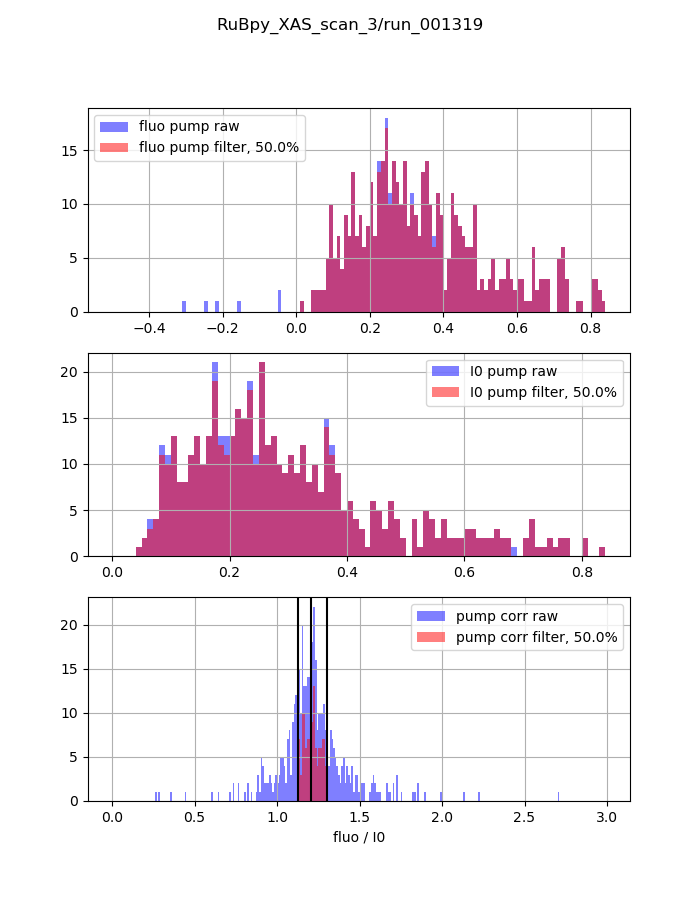

quantile range = 0.25 0.75


In [7]:
plt.figure(figsize = (7,9))
plt.suptitle(scan_name +"/"+ f.split('.')[0])

plt.subplot(311)
plt.hist(DataFluo_pump_shot_raw, bins =np.arange(-0.5,0.85,0.01), facecolor='blue', label="fluo pump raw", alpha=0.5)
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="fluo pump filter, {}%".format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(312)
plt.hist(IzeroFEL_pump_raw, bins =np.arange(0,0.85,0.01), facecolor='blue', label='I0 pump raw', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label ='I0 pump filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(313)
x_axis = np.arange(0,3,0.01)
plt.hist(DataFluo_pump_shot_norm_raw, bins =x_axis, facecolor='blue', label='pump corr raw', alpha=0.5)
plt.hist(DataFluo_pump_shot_norm, bins =x_axis, facecolor='red', label='pump corr filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")
plt.axvline(med, color = 'k') 
plt.axvline(qnt_low, color = 'k')
plt.axvline(qnt_high, color = 'k') 
plt.xlabel('fluo / I0')

plt.show()
print ('quantile range = {}'.format(0.5 - quantile_corr/2), 0.5 + quantile_corr/2)

# Now load the full scan

In [10]:
fc = FileChooser('/sf/alvra/data/p18741/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18741/raw/scan_info', filename='', show_hidden='False')

### First, without any filtering of the data, check data distributions with quantiles 

In [31]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_energy]

########################################################
json_file = fc.selected
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])

numFiles = 36      #use 36 for the scan RuBpy_XAS_scan_3 due to a problem with file #37

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

Energy_eV = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, filename)
        
        #(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
        # DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_energy)
        
        Energy_shot = results[channel_energy]
        
        IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
        IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
        DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
        DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
  
        print ("Loaded {} shots".format(len(DataFluo_pump_shot)))
    
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
              
        DataFluo_pump.append(np.nanquantile(df_pump, quantiles))
        DataFluo_unpump.append(np.nanquantile(df_unpump, quantiles))
        Pump_probe.append(np.nanquantile(df_pump_probe, quantiles))
        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.median(Energy_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)

Energy_eV = np.asarray(Energy_eV)

print ("Job done!")


step 36 of 36 : Processing /sf/alvra/data/p18741/raw/scan_data/RuBpy_XAS_scan_3/run_001320.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 500 pump and 500 unpump shots
Loaded 500 shots
Job done!


<IPython.core.display.Javascript object>


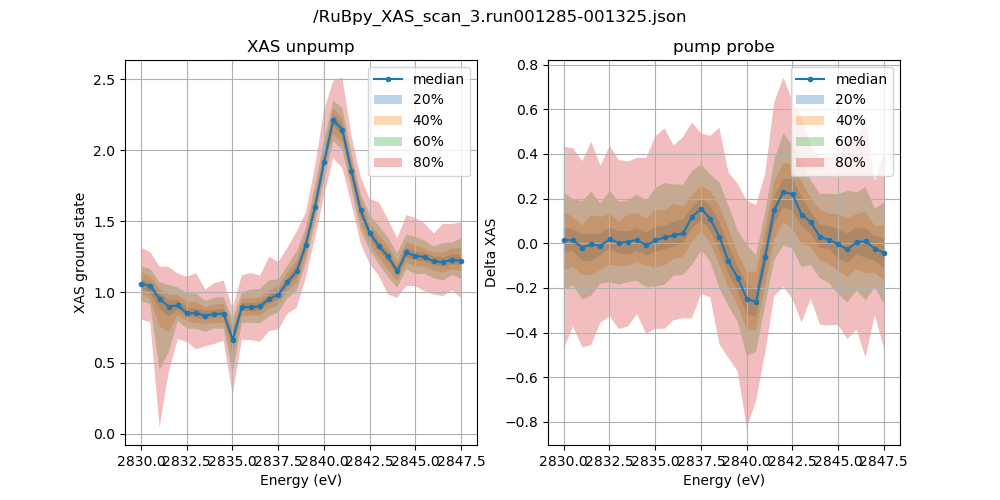

In [32]:
plt.figure(figsize = (10,5))
plt.suptitle(json_file.split('scan_info')[1], fontsize=12)

plt.subplot(1,2,1)
plt.plot(Energy_eV, DataFluo_unpump[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,4]),np.array(DataFluo_unpump[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,3]),np.array(DataFluo_unpump[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,2]),np.array(DataFluo_unpump[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,1]),np.array(DataFluo_unpump[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('XAS unpump')
plt.legend(loc="best")
plt.ylabel("XAS ground state")
plt.xlabel("Energy (eV)")

plt.subplot(1,2,2)
plt.plot(Energy_eV, Pump_probe[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(Pump_probe[:,4]),np.array(Pump_probe[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(Pump_probe[:,3]),np.array(Pump_probe[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(Pump_probe[:,2]),np.array(Pump_probe[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(Pump_probe[:,1]),np.array(Pump_probe[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('pump probe')
plt.legend(loc="best")
plt.ylabel("Delta XAS")
plt.xlabel("Energy (eV)")

plt.show()

### Now choose thresholds and quantile

In [34]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.1

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_energy]

########################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])

numFiles = 36      #use 36 for the scan RuBpy_XAS_scan_3 due to a problem with file #37

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

Energy_eV = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, filename)
        
        #(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
        # DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_energy)
        
        Energy_shot = results[channel_energy]
        
        IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
        IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
        DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
        DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
        
        print ("Loaded {} shots".format(len(DataFluo_pump_shot)))
        
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)
                  
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")


step 36 of 36 : Processing /sf/alvra/data/p18442/raw/scan_data/RuBpy_XAS_scan_3/run_001320.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 500 pump and 500 unpump shots
Loaded 500 shots
Job done!


# Plot energy scans

<IPython.core.display.Javascript object>


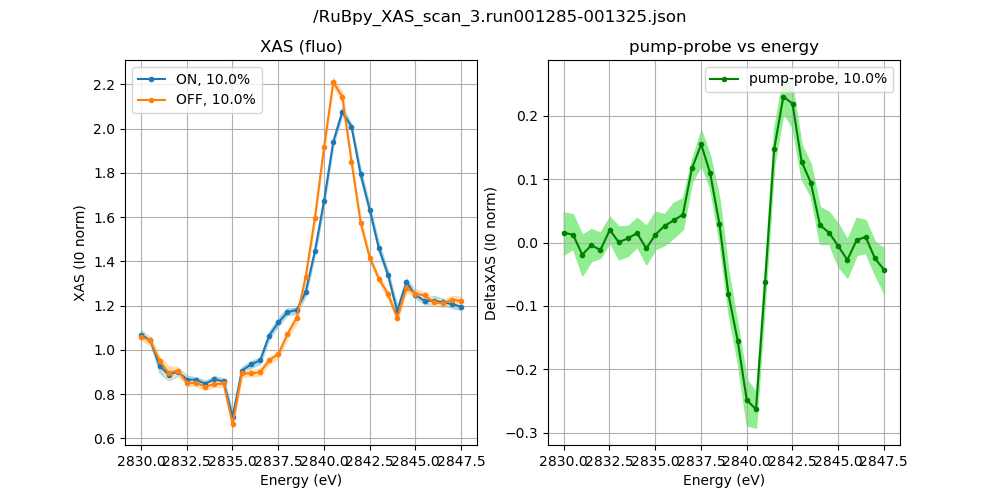

In [35]:
plt.figure(figsize = (10,5))
plt.suptitle(json_file.split('scan_info')[1], fontsize=12)

Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS_pump = DataFluo_pump[:,0]
err_low_pump = DataFluo_pump[:,1]
err_high_pump = DataFluo_pump[:,2]
XAS_unpump = DataFluo_unpump[:,0]
err_low_unpump = DataFluo_unpump[:,1]
err_high_unpump = DataFluo_unpump[:,2]
XAS_pump_probe = Pump_probe[:,0]
err_low_pump_probe = Pump_probe[:,1]
err_high_pump_probe = Pump_probe[:,2]

plt.subplot(1,2,1)
plt.plot(Energy_eV, XAS_pump, label='ON, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low_pump, err_high_pump, color='lightblue')

plt.plot(Energy_eV, XAS_unpump, label='OFF, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low_unpump, err_high_unpump, color='navajowhite')

plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Energy_eV, XAS_pump_probe, label='pump-probe, {}%'.format(quantile_corr*100),color='green', marker='.')
plt.fill_between(Energy_eV,err_low_pump_probe, err_high_pump_probe, color='lightgreen')
plt.xlabel("Energy (eV)")
plt.ylabel ("DeltaXAS (I0 norm)")
plt.gca().set_title('pump-probe vs energy')
plt.legend(loc="best")
plt.grid()

plt.show()



## cell to export data

In [ ]:
import pandas as pd
DIR_save = "/das/work/p17/p17589/Extract_data_MbNo/"
file2save = DIR_save + scan_name + ".txt"
pd.DataFrame({
    'pump_probe': Pump_probe_15uJ,
    'signal_on' : DataFluo_pump_15uJ,
    'signal_off' : DataFluo_unpump_15uJ,
}).to_csv(file2save,index=False)